Extracted files to /content/pnevmoniya/
Loading data...
Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Creating model...
Training model...
Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.8840 - loss: 0.4625 - val_accuracy: 0.7430 - val_loss: 2.0208 - learning_rate: 0.0010
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 119s 848ms/step - accuracy: 0.9478 - loss: 0.2307 - val_accuracy: 0.7430 - val_loss: 4.2178 - learning_rate: 0.0010
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 112s 823ms/step - accuracy: 0.9610 - loss: 0.1682 - val_accuracy: 0.7430 - val_loss: 5.1320 - learning_rate: 0.0010
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 143s 826ms/step - accuracy: 0.9606 - loss: 0.1432 - val_accuracy: 0.7430 - val_loss: 3.0010 - learning_rate: 0.0010
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 112s 826ms/step - accuracy: 0.9804 - loss: 0.0969 - val_accuracy: 0.7641 - val_loss: 1.0969 - learning_rate: 1.0000e-04
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 142

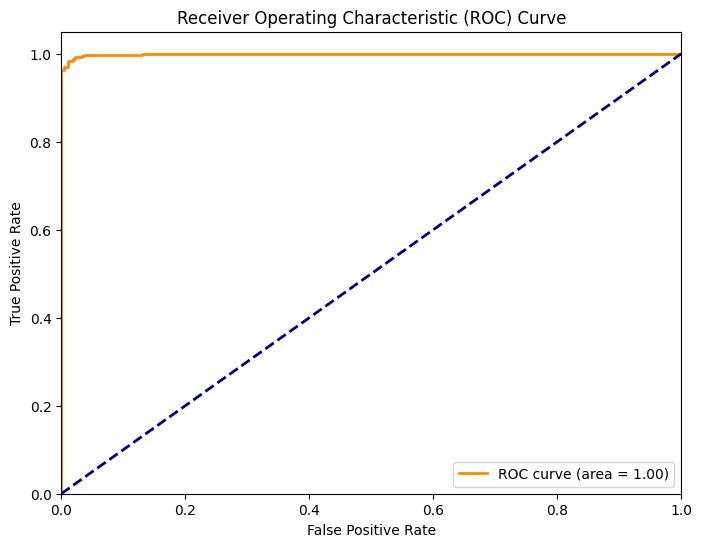

Preparing submission...
Found 624 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 533ms/step
Submission file 'submission.csv' has been created.


<Figure size 640x480 with 0 Axes>

In [20]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd

# Define constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

# Kaggle setup and data extraction
if not os.path.exists('/root/.kaggle'):
    os.makedirs('/root/.kaggle')
if os.path.exists('/content/kaggle.json'):
    os.system('cp /content/kaggle.json /root/.kaggle/')
    os.system('chmod 600 /root/.kaggle/kaggle.json')
    os.system('kaggle competitions download -c pnevmoniya -p /content/')
    zip_file_path = "/content/pnevmoniya.zip"
    extract_to = "/content/pnevmoniya/"
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted files to {extract_to}")
else:
    print("Kaggle API key not found. Please upload kaggle.json to the current directory.")

# Data directories
train_dir = "/content/pnevmoniya/train"
test_dir = "/content/pnevmoniya/test"
sample_solution_path = '/content/pnevmoniya/sample_submission.csv'

# Data loading function
def load_data():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.8, 1.2],
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        subset='validation',
        shuffle=False
    )

    return train_generator, validation_generator

# Model creation function
def create_model():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Training function
def train_model(model, train_generator, validation_generator):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)]
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=EPOCHS,
        callbacks=callbacks
    )
    return history

# Function to evaluate and print classification metrics
def evaluate_classification(true_labels, predictions):
    print("Converting predictions to binary labels...")
    predicted_labels = (predictions > 0.5).astype(int)

    print("Printing classification report...")
    print(classification_report(true_labels, predicted_labels))

    print("Printing confusion matrix...")
    cm = confusion_matrix(true_labels, predicted_labels)
    print(cm)

# Function to plot ROC curve and calculate AUC
def plot_roc_curve(true_labels, predictions):
    print("Computing ROC curve and AUC...")
    fpr, tpr, thresholds = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)

    print("Plotting ROC curve...")
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    plt.savefig('roc_curve.png')  # Save the plot to a file

# Evaluation function
def evaluate_model(model, validation_generator):
    print("Generating predictions...")
    predictions = model.predict(validation_generator)
    predictions = predictions.flatten()

    print("Retrieving true labels...")
    true_labels = validation_generator.classes

    print("Evaluating classification metrics...")
    evaluate_classification(true_labels, predictions)

    print("Plotting ROC curve...")
    plot_roc_curve(true_labels, predictions)

# Submission preparation function
def prepare_submission(model):
    test_image_names = os.listdir(test_dir)
    test_df = pd.DataFrame({'filename': test_image_names})
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=test_dir,
        x_col='filename',
        y_col=None,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode=None,
        shuffle=False
    )
    test_predictions = model.predict(test_generator)
    test_predictions = test_predictions.flatten()
    submission = pd.DataFrame({'id': test_df['filename'], 'labels': (test_predictions > 0.5).astype(int)})
    submission.to_csv('submission.csv', index=False)

# Main execution
def main():
    print("Loading data...")
    train_generator, validation_generator = load_data()

    print("Creating model...")
    model = create_model()

    print("Training model...")
    history = train_model(model, train_generator, validation_generator)

    print("Evaluating model...")
    evaluate_model(model, validation_generator)

    print("Preparing submission...")
    prepare_submission(model)

    print("Submission file 'submission.csv' has been created.")

if __name__ == '__main__':
    main()